In [1]:
import sys
sys.path.append('..')

import numpy as np
from src.helpers import load_csv_data, standardize, flatten_jet_features, predict_labels, create_csv_submission, get_jet_indexes, jet_indexes, compute_accuracy
from src.linear.implementations import ridge_regression
from src.split import split_data
from src.polynomials import build_poly_matrix_vandermonde
from src.plots import plot_train_test, plot_poly_degree
from src.linear.loss import compute_loss

%reload_ext autoreload
%autoreload 2

In [2]:
# Import data
y, x_raw, ids = load_csv_data('../data/train.csv')

## Plain ridge regression

In [4]:
x, mean_x, std_x = standardize(x_raw)
tx = np.c_[np.ones((y.shape[0], 1)), x]

In [7]:
ratio = 0.8
tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

In [13]:
loss, w = ridge_regression(y_train, tx_train, 0.01)

In [14]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [15]:
(y_pred == y_test).sum() / y_test.shape[0]

0.69216

## Ridge regression with flattened jet features

In [16]:
x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = np.c_[np.ones((y.shape[0], 1)), x]

In [17]:
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

In [18]:
loss, w = ridge_regression(y_train, tx_train, 0.01)

In [19]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [20]:
(y_pred == y_test).sum() / y_test.shape[0]

0.70966

## Ridge regression with flattened jet features and polynomial degree

In [13]:
x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = build_poly_matrix_vandermonde(x, 12)

In [14]:
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

In [15]:
loss, w = ridge_regression(y_train, tx_train, 0.0001)

In [16]:
y_pred = predict_labels(w, tx_test, mode='linear')

In [17]:
(y_pred == y_test).sum() / y_test.shape[0]

0.79616

Result with lambda = 0.0001, degree = 12 => 0.79616

In [ ]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
y_pred = predict_labels(w, tx_test, mode='linear')
create_csv_submission(ids, y_pred, '../submissions/10-24.22-32.csv')

## Ridge regression with different sets

In [3]:
degree = 7
ratio = 0.8
lambda_ = 0.0001

x_train, y_train, x_test, y_test = split_data(x_raw, y, ratio)

train_jet_indexes= get_jet_indexes(x_train)
test_jet_indexes = get_jet_indexes(x_test)

In [6]:
ws = []
accuracies = []

y_pred = np.zeros((x_test.shape[0], 1))

for i in train_jet_indexes:
    
    tx_train_raw = x_train[train_jet_indexes[i]]
    tx_test_raw = x_test[test_jet_indexes[i]]
    
    tx_train_std = standardize(tx_train_raw)[0]
    tx_test_std = standardize(tx_test_raw)[0]
    
    tx_train_rem = np.delete(tx_train_std, jet_indexes[i], axis=1)
    tx_test_rem = np.delete(tx_test_std, jet_indexes[i], axis=1)
    
    tx_train = build_poly_matrix_vandermonde(tx_train_rem, degree)
    tx_test = build_poly_matrix_vandermonde(tx_test_rem, degree)
    
    loss, w = ridge_regression(y_train[train_jet_indexes[i]], tx_train, lambda_)
    
    y_pred[test_jet_indexes[i]] = predict_labels(w, tx_test, mode='linear')
    ws.append(w)

In [7]:
tot_accuracy = (y_pred == y_test).sum() / (y_test.shape[0])
tot_accuracy

0.71004

With degree 12, lambda = 0.001 => test accuracy = 0.710

In [9]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
tx_sub_split, y_sub_split, ids_split = jet_split(x_sub_raw, y_sub, ids_sub, degree)

In [10]:
y_split_pred = [predict_labels(ws[i], x, mode='linear') for i, x in enumerate(tx_sub_split)]

In [12]:
y_split_cat = np.concatenate(y_split_pred)
ids_split_cat = np.concatenate(ids_split)
create_csv_submission(ids_split_cat, y_split_cat, '../submissions/10-24.21-37.csv')

## Ridge regression with lambda grid_search

In [3]:
def ridge_regression_lambda_search(x, y, lambdas, degree, ratio):

    x = flatten_jet_features(x_raw)
    x, mean_x, std_x = standardize(x)
    tx = build_poly_matrix_vandermonde(x, degree)

    tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, lambda_ in enumerate(lambdas):

        tr_loss, w = ridge_regression(y_train, tx_train, lambda_)
        te_loss = compute_loss(y_test, tx_test, w)
        
        tr_acc = compute_accuracy(tx_train, w, y_train, mode='linear')
        te_acc = compute_accuracy(tx_test, w, y_test, mode='linear')

        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        ws.append(w)

        print("proportion={p}, degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    plot_train_test(acc_tr, acc_te, lambdas, degree)
    return ws, rmse_tr, rmse_te

proportion=0.8, degree=12, lambda=0.000010, Training RMSE=0.756, Testing RMSE=10.606
proportion=0.8, degree=12, lambda=0.000023, Training RMSE=0.760, Testing RMSE=8.879
proportion=0.8, degree=12, lambda=0.000052, Training RMSE=0.765, Testing RMSE=4.703
proportion=0.8, degree=12, lambda=0.000118, Training RMSE=0.770, Testing RMSE=1.670
proportion=0.8, degree=12, lambda=0.000268, Training RMSE=0.774, Testing RMSE=7.912
proportion=0.8, degree=12, lambda=0.000611, Training RMSE=0.778, Testing RMSE=13.023
proportion=0.8, degree=12, lambda=0.001389, Training RMSE=0.782, Testing RMSE=15.666
proportion=0.8, degree=12, lambda=0.003162, Training RMSE=0.789, Testing RMSE=15.701
proportion=0.8, degree=12, lambda=0.007197, Training RMSE=0.802, Testing RMSE=10.731
proportion=0.8, degree=12, lambda=0.016379, Training RMSE=0.820, Testing RMSE=1.235
proportion=0.8, degree=12, lambda=0.037276, Training RMSE=0.841, Testing RMSE=10.504
proportion=0.8, degree=12, lambda=0.084834, Training RMSE=0.860, Testi

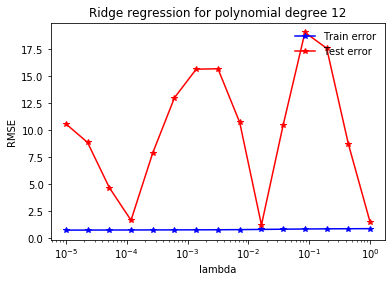

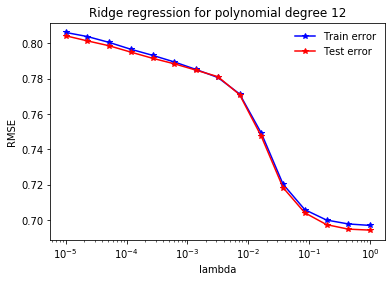

In [4]:
lambdas = np.logspace(-5, 0, 15)
degree = 12
ratio = 0.8

ws, rmse_tr, rmse_te = ridge_regression_lambda_search(x_raw, y, lambdas, degree, ratio)

In [3]:
def ridge_regression_degree_search(x, y, lambda_, degrees, ratio):

    x = flatten_jet_features(x_raw)
    x, mean_x, std_x = standardize(x)

    rmse_tr = []
    rmse_te = []
    acc_tr = []
    acc_te = []
    ws = []

    for ind, degree in enumerate(degrees):
        
        tx = build_poly_matrix_vandermonde(x, degree)
        tx_train, y_train, tx_test, y_test = split_data(tx, y, ratio)

        tr_loss, w = ridge_regression(y_train, tx_train, lambda_)
        te_loss = compute_loss(y_test, tx_test, w)
        
        tr_acc = compute_accuracy(tx_train, w, y_train, mode='linear')
        te_acc = compute_accuracy(tx_test, w, y_test, mode='linear')

        rmse_tr.append(np.math.sqrt(2 * tr_loss))
        rmse_te.append(np.math.sqrt(2 * te_loss))
        acc_tr.append(tr_acc)
        acc_te.append(te_acc)
        ws.append(w)

        print("proportion={p}, degree={d}, lambda={l:.6f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                   p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    plot_poly_degree(rmse_tr, rmse_te, degrees, lambda_)
    plot_poly_degree(acc_tr, acc_te, degrees, lambda_)
    return ws, rmse_tr, rmse_te

proportion=0.8, degree=0, lambda=0.000100, Training RMSE=0.949, Testing RMSE=0.950
proportion=0.8, degree=1, lambda=0.000100, Training RMSE=0.844, Testing RMSE=0.846
proportion=0.8, degree=2, lambda=0.000100, Training RMSE=0.830, Testing RMSE=0.830
proportion=0.8, degree=3, lambda=0.000100, Training RMSE=0.818, Testing RMSE=0.820
proportion=0.8, degree=4, lambda=0.000100, Training RMSE=0.802, Testing RMSE=0.804
proportion=0.8, degree=5, lambda=0.000100, Training RMSE=0.789, Testing RMSE=0.790
proportion=0.8, degree=6, lambda=0.000100, Training RMSE=0.783, Testing RMSE=0.788
proportion=0.8, degree=7, lambda=0.000100, Training RMSE=0.783, Testing RMSE=0.837
proportion=0.8, degree=8, lambda=0.000100, Training RMSE=0.778, Testing RMSE=0.876
proportion=0.8, degree=9, lambda=0.000100, Training RMSE=0.774, Testing RMSE=0.902
proportion=0.8, degree=10, lambda=0.000100, Training RMSE=0.774, Testing RMSE=1.476
proportion=0.8, degree=11, lambda=0.000100, Training RMSE=0.770, Testing RMSE=7.125
pr

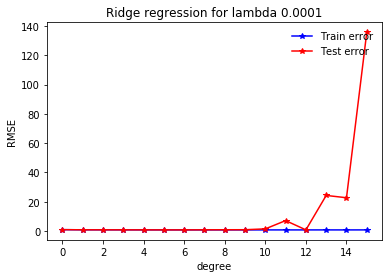

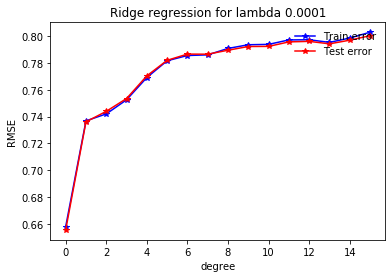

In [4]:
lambda_ = 0.0001
degrees = range(16)
ratio = 0.8

ws, rmse_tr, rmse_te = ridge_regression_degree_search(x_raw, y, lambda_, degrees, ratio)

The best combination seems to be with lambda = 0.0001 and degree = 15

In [3]:
lambda_ = 0.0001
degree = 15

x = flatten_jet_features(x_raw)
x, mean_x, std_x = standardize(x)
tx = build_poly_matrix_vandermonde(x, degree)
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.8)

loss, w = ridge_regression(y_train, tx_train, lambda_)

In [4]:
y_pred = predict_labels(w, tx_test, mode='linear')
(y_pred == y_test).sum() / y_test.shape[0]

0.8004

In [ ]:
y_sub, x_sub_raw, ids_sub = load_csv_data('../data/test.csv')
x_sub = flatten_jet_features(x_sub_raw)
x_sub, mean_x, std_x = standardize(x_sub)
tx_sub = build_poly_matrix_vandermonde(x_sub, degree)
loss, w = ridge_regression(y_sub, tx_sub, lambda_)

In [ ]:
y_sub = predict_labels(w, tx_sub, mode='linear')